In [19]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat, periodic_features
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
plt.style.use('ggplot')

In [20]:
df_price = pd.read_csv('../data/BTC-USD.csv', parse_dates=True)
# df_price = df_price[1000:]
df_price['Adj Close'] = np.log(df_price['Adj Close'])
data = torch.tensor(df_price['Adj Close'].values.astype(float))

In [21]:
# df_price = pd.read_csv('../data/euro-daily-hist_1999_2022.csv', parse_dates=True)
# # data = torch.tensor(df_price['[Danish krone ]'].values.astype(float))
# df_price = df_price.set_index('Period\\Unit:')
# df_price.index = pd.to_datetime(df_price.index)

In [22]:
# df_price = df_price['2022-03-25':'2014-09-17'].sort_index()
# data = torch.tensor(df_price['[Danish krone ]'].values.astype(float))

In [23]:
data = data.unsqueeze(-1)

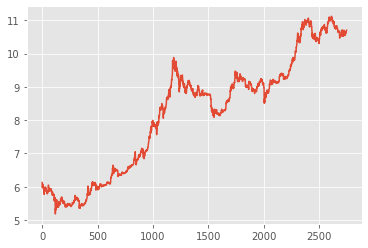

In [24]:
plt.plot(data)

In [25]:
T0 = 0
T1 = data.size(-2)-30
T2 = data.size()[0]

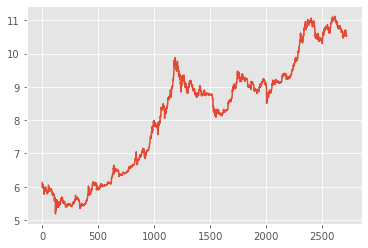

In [26]:
plt.plot(data[:T1])

In [27]:
class Model1(ForecastingModel):
    # We then implement the .model() method. Since this is a generative model, it shouldn't
    # look at data; however it is convenient to see the shape of data we're supposed to
    # generate, so this inputs a zeros_like(data) tensor instead of the actual data.
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)  # Should be 1 in this univariate tutorial.
        feature_dim = covariates.size(-1)

        # The first part of the model is a probabilistic program to create a prediction.
        # We use the zero_data as a template for the shape of the prediction.
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))
        prediction = bias + (weight * covariates).sum(-1, keepdim=True)
        # The prediction should have the same shape as zero_data (duration, obs_dim),
        # but may have additional sample dimensions on the left.
        assert prediction.shape[-2:] == zero_data.shape

        # The next part of the model creates a likelihood or noise distribution.
        # Again we'll be Bayesian and write this as a probabilistic program with
        # priors over parameters.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)

        # The final step is to call the .predict() method.
        self.predict(noise_dist, prediction)



In [28]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(len(data))) / 365
covariates = torch.cat([time.unsqueeze(-1),
                        periodic_features(T2, 365.25 / 7)], dim=-1)

Wall time: 5 ms


In [29]:
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 4399.65
INFO 	 step  100 loss = 0.905545
INFO 	 step  200 loss = 0.899171
INFO 	 step  300 loss = 0.885072
INFO 	 step  400 loss = 0.880112
INFO 	 step  500 loss = 0.876572
INFO 	 step  600 loss = 0.874289
INFO 	 step  700 loss = 0.868984
INFO 	 step  800 loss = 0.869827
INFO 	 step  900 loss = 0.869277
INFO 	 step 1000 loss = 0.868117


torch.Size([1000, 30, 1]) torch.Size([30])


(2700.0, 2883.3)

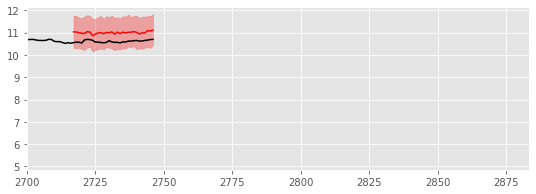

In [30]:
plt.style.use('ggplot')

samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.xlim(2700, None)

In [14]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        # We'll sample a time-global scale parameter outside the time plate,
        # then time-local iid noise inside the time plate.
        drift_scale = pyro.sample("drift_scale",
                                  dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            # We'll use a reparameterizer to improve variational fit. The model would still be
            # correct if you removed this context manager, but the fit appears to be worse.
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))

        # After we sample the iid "drift" noise we can combine it in any time-dependent way.
        # It is important to keep everything inside the plate independent and apply dependent
        # transforms outside the plate.
        motion = drift.cumsum(-2)  # A Brownian motion.

        # The prediction now includes three terms.
        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape

        # Construct the noise distribution and predict.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)
        self.predict(noise_dist, prediction)

In [15]:
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = periodic_features(T2, 365.25 / 7)
forecaster = Forecaster(Model2(), data[:T1], covariates[:T1], learning_rate=0.5,
                        time_reparam="dct", num_steps=10001,
                       )

C:\Users\mwasi\anaconda3\envs\Data\lib\site-packages\pyro\poutine\reparam_messenger.py:111: RuntimeWarning: At pyro.sample('drift_decentered',...), HaarReparam does not commute with initialization; falling back to default initialization.
  warnings.warn(
INFO 	 step    0 loss = 2.81631e+09
INFO 	 step  100 loss = 1.99785
INFO 	 step  200 loss = 2.51636
INFO 	 step  300 loss = 1.48576
INFO 	 step  400 loss = 1.03991
INFO 	 step  500 loss = 1.65298
INFO 	 step  600 loss = 1.19005
INFO 	 step  700 loss = 1.34652
INFO 	 step  800 loss = 1.22345
INFO 	 step  900 loss = 1.05944
INFO 	 step 1000 loss = 1.42255
INFO 	 step 1100 loss = 1.17084
INFO 	 step 1200 loss = 3.16749
INFO 	 step 1300 loss = 1.62329
INFO 	 step 1400 loss = 0.849058
INFO 	 step 1500 loss = 0.985529
INFO 	 step 1600 loss = 3.20104
INFO 	 step 1700 loss = 0.741986
INFO 	 step 1800 loss = 0.975313
INFO 	 step 1900 loss = 1.1137
INFO 	 step 2000 loss = 2.04266
INFO 	 step 2100 loss = 0.71713
INFO 	 step 2200 loss = 0.809581
I

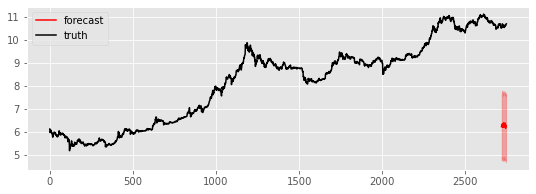

In [16]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
# plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
# plt.ylabel("log(# rides)")
# plt.xlabel("Week after 2011-01-01")
# plt.xlim(1717, None)
# plt.ylim(-1e11, 1.5e11)

plt.legend(loc="best");

In [17]:
T1

2717